# Delayed Acceptance with Random Subchain Lengths

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

from scipy.integrate import solve_ivp

import tinyDA as tda

In [2]:
np.random.seed(987)

### Define the predator/prey model
We use scipy.integrate.solve_ivp to solve the predator-prey model. The method `dydx` is the differential equation.

In [3]:
class PredatorPreyModel:
    def __init__(self, datapoints, method):
        
        # set the timesteps, where we are collecting the model output
        self.datapoints = datapoints
        
        # set the span of the integration.
        self.t_span = [0, self.datapoints[-1]]
        
        # set the integration method
        self.method = method
        
    def dydx(self, t, y, a, b, c, d):
        # Lotka-Volterra Model model, see e.g. https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations
        return np.array([a*y[0] - b*y[0]*y[1], c*y[0]*y[1] - d*y[1]])

    def __call__(self, parameters):
        
        # extract the parameters, and take the exponential to keep them positive
        P_0, Q_0, a, b, c, d = np.exp(parameters)
        
        # solve the initial value problem.
        self.y = solve_ivp(lambda t, y: self.dydx(t, y, a, b, c, d), self.t_span, np.array([P_0, Q_0]), t_eval=self.datapoints, method=self.method) 
        
        # return the results, only if the integration succeeded.
        if self.y.success:
            return np.array(self.y.y.flatten()), np.array(self.y.y.flatten())[0]
        else:
            return np.zeros_like(self.y.y.flatten()), 0


### Set up the true model

In [4]:
# #set the true parameters
P_0 = 10
Q_0 = 5
a = 1.0
b = 0.3
c = 0.2
d = 1.0

# collect the parameters in a vector and take the logarithm. 
# we sample the log of the parameters and take the exponential
# inside the model to keep the parameters positive.
true_parameters = np.log(np.array([P_0, Q_0, a, b, c, d]))

# set the integration points.
t_span = [0,12]
n_eval = 1000
t_eval = np.linspace(t_span[0], t_span[1], n_eval)

# initalise the true model and solve it
my_model = PredatorPreyModel(t_eval, method='Radau')
y_true = my_model(true_parameters)[0]

### Set up the forward models

In [5]:
n_data = 25 # number of datapoints
t_eval_data = np.linspace(t_span[0], t_span[1], n_data) # datapoints

# fine model
my_fine_model = PredatorPreyModel(t_eval_data, method='Radau') # initialise model

# coarse model
my_coarse_model = PredatorPreyModel(t_eval_data, method='RK45') # initialise model

### Generate data

In [6]:
# set the noise level
sigma = 1.0

noise = np.random.normal(scale=sigma, size=(t_eval_data.size,2)) # fine noise
data = my_fine_model(true_parameters)[0] + np.hstack((noise[:,0], noise[:,1])) # noisy fine data.
data[data < 0] = 0 # make sure all the data is positive.

### Plot the true model and the data

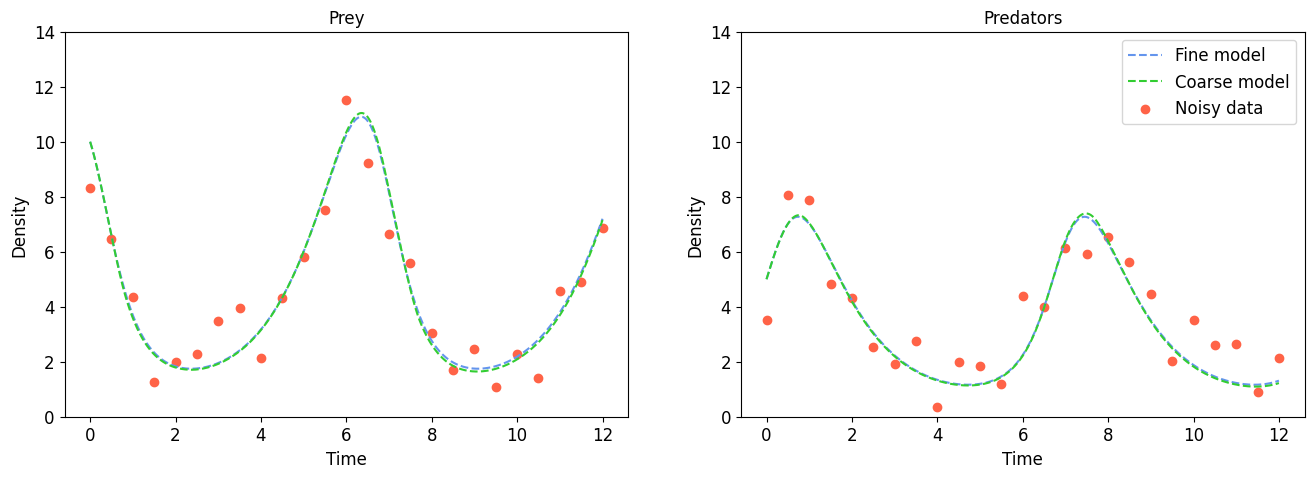

In [7]:
y_coarse = PredatorPreyModel(t_eval, method='RK45')(true_parameters)[0]
fig, axes = plt.subplots(figsize=(16,5), nrows=1, ncols=2)

axes[0].set_title('Prey', fontsize=12)
axes[0].plot(t_eval, y_true[:n_eval], '--', color='cornflowerblue')
axes[0].plot(t_eval, y_coarse[:n_eval], '--', color='limegreen')
axes[0].scatter(t_eval_data, data[:n_data], color='tomato')
axes[0].tick_params(axis='both', labelsize=12)
axes[0].set_xlabel('Time', fontsize=12)
axes[0].set_ylim(0, 14); axes[0].set_ylabel('Density', fontsize=12)
#axes[0].legend(loc=2, fontsize=12)

axes[1].set_title('Predators', fontsize=12)
axes[1].plot(t_eval, y_true[n_eval:], '--', color='cornflowerblue', label='Fine model')
axes[1].plot(t_eval, y_coarse[n_eval:], '--', color='limegreen', label='Coarse model')
axes[1].scatter(t_eval_data, data[n_data:], color='tomato', label='Noisy data')
axes[1].tick_params(axis='both', labelsize=12)
axes[1].set_xlabel('Time', fontsize=12)
axes[1].set_ylim(0, 14); axes[1].set_ylabel('Density', fontsize=12)
axes[1].legend(loc=1, fontsize=12)

plt.show()

### Set up the statistical model  and draw some samples from the prior
We need a fairly well-informed prior, since the model is nonlinear and the data is quite noisy. Hence, we assume that we have pretty good knowledge about the birth- and death rates of the prey and predators, respectively. The predation rate and the growth rate for the predators are left to be fairly uncertain.

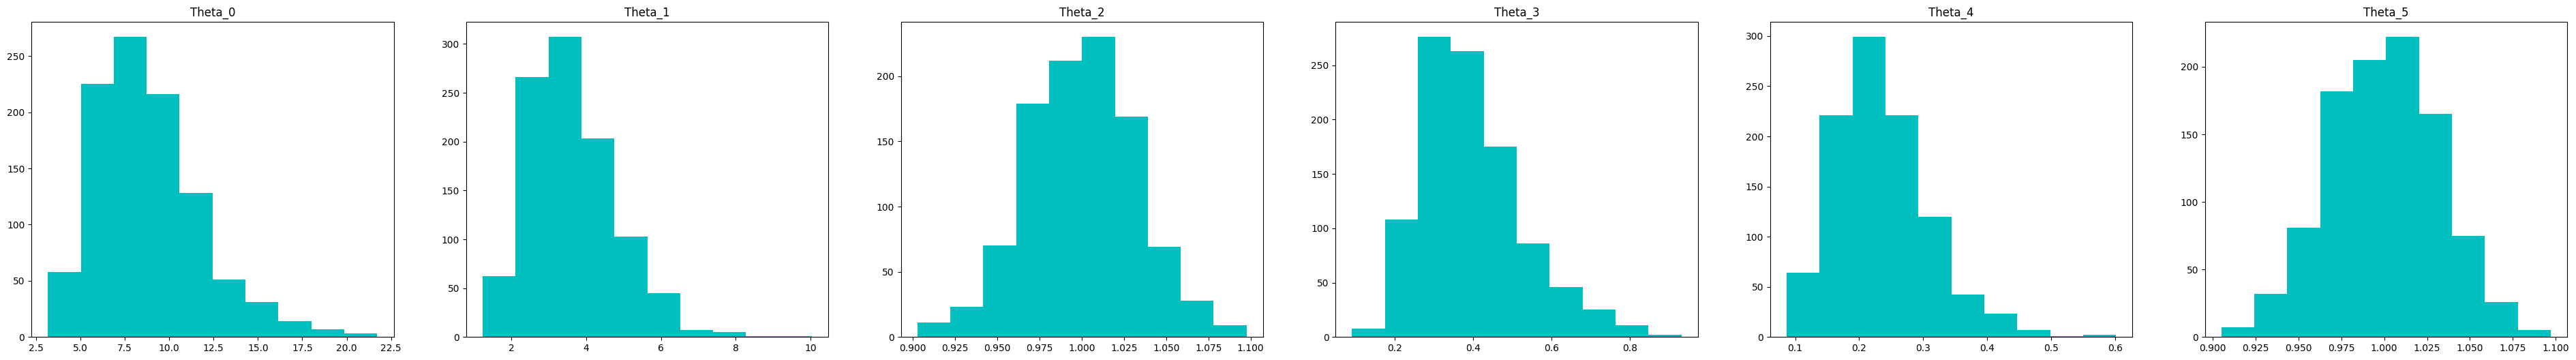

In [8]:
# prior distribution
mean_prior = np.array([np.log(data[0]), np.log(data[n_data]), 0, -1, -1.5, 0])
cov_prior = np.diag([0.1, 0.1, 0.001, 0.1, 0.1, 0.001])
my_prior = stats.multivariate_normal(mean_prior, cov_prior)

# draw some samples and plot them
prior_samples = np.exp(my_prior.rvs(1000))
fig, axes = plt.subplots(nrows=1, ncols=my_prior.dim, figsize = (8*my_prior.dim, 6))
for i in range(my_prior.dim):
    axes[i].set_title('Theta_{}'.format(i))
    axes[i].hist(prior_samples[:,i], color='c')

In [9]:
# define the likelihood
cov_likelihood = sigma**2*np.eye(data.size)

my_loglike_fine = tda.GaussianLogLike(data, cov_likelihood)
my_loglike_coarse = tda.AdaptiveGaussianLogLike(data, cov_likelihood)
my_loglike_middle = tda.AdaptiveGaussianLogLike(data, cov_likelihood)

### Set up the link factories and get the MAP point

In [10]:
# set up the link factories
my_posterior_coarse = tda.Posterior(my_prior, my_loglike_coarse, my_coarse_model)
my_posterior_middle = tda.Posterior(my_prior, my_loglike_middle, my_coarse_model)
my_posterior_fine = tda.Posterior(my_prior, my_loglike_fine, my_fine_model)

my_posteriors = [my_posterior_coarse, my_posterior_fine]
posteriors = [my_posterior_coarse, my_posterior_middle, my_posterior_fine]

In [11]:
# get the maximum a posteriori point.
MAP = tda.get_MAP(my_posterior_fine)

### Set up the proposal

In [12]:
# random walk Metropolis
#rwmh_cov = np.eye(2)
#rmwh_scaling = 0.1
#rwmh_adaptive = True
#my_proposal = tda.GaussianRandomWalk(C=rwmh_cov, scaling=rmwh_scaling, adaptive=rwmh_adaptive)

# preconditioned Crank-Niconson
#pcn_scaling = 0.1
#pcn_adaptive = True
#my_proposal = tda.CrankNicolson(scaling=pcn_scaling, adaptive=pcn_adaptive)

# Adaptive Metropolis
am_cov = np.eye(true_parameters.size)
am_t0 = 100
am_sd = None
am_epsilon = 1e-6
am_adaptive = True
my_proposal = tda.AdaptiveMetropolis(C0=am_cov, t0=am_t0, sd=am_sd, epsilon=am_epsilon)

### Sample

In [13]:
import os
if "CI" in os.environ:
    iterations = 120
    burnin = 20
else:
    iterations = 2500
    burnin = 500

In [14]:
# initialise the chain
#my_chain = tda.sample([my_posterior_coarse, my_posterior_fine], my_proposal, iterations=iterations, n_chains=1, subsampling_rate=100, adaptive_error_model='state-independent')
my_chain = tda.sample(my_posteriors, my_proposal, iterations=iterations, n_chains=1, initial_parameters=MAP, subchain_length=30, randomize_subchain_length=True, adaptive_error_model='state-independent')#, randomize_subchain_length='True')
#my_chain = tda.sample(my_posteriors, my_proposal, iterations=iterations, n_chains=2, initial_parameters=MAP, subsampling_rate=10, randomize_subchain_length=True, adaptive_error_model='state-independent')

Sampling chain 1/1


Running chain, α_c = 1.000, α_f = 1.00:   0%|          | 0/2500 [00:00<?, ?it/s]

Running chain, α_c = 0.268, α_f = 0.86: 100%|██████████| 2500/2500 [04:22<00:00,  9.51it/s]


In [18]:
my_chain.keys()

dict_keys(['sampler', 'n_chains', 'iterations', 'subchain_length', 'chain_coarse_0', 'chain_fine_0'])

In [16]:
samples = tda.get_samples(my_chain, level='fine')#, attribute = 'stats')
print(samples.keys())
print(len(samples['chain_0']))

dict_keys(['sampler', 'n_chains', 'attribute', 'subchain_length', 'level', 'chain_0', 'iterations', 'dimension'])
2501


In [21]:
samples = tda.get_samples(my_chain, level='promoted_coarse')#, attribute = 'stats')
print(samples.keys())
print(len(samples['chain_0']))

KeyError: 'chain_promoted_coarse_0'

In [18]:
chains = []

In [19]:
chains.append(tda.DAChain(my_posterior_coarse, my_posterior_fine, my_proposal, initial_parameters=MAP, subchain_length=40, randomize_subchain_length=True, adaptive_error_model='state-independent'))

In [20]:
chains[0].sample(120)

Running chain, α_c = 0.352, α_f = 0.92: 100%|██████████| 120/120 [00:18<00:00,  6.55it/s]


In [21]:
print(len(chains[0].chain_fine))
print(len(chains[0].promoted_coarse))

121
121


In [ ]:
chains[0].chain_fine[-1]

-21.654911620612346

: 

In [26]:
tda.sampler._get_result_da(chains, iterations=120,subchain_length = 40,store_coarse_chain=True).keys()

dict_keys(['sampler', 'n_chains', 'iterations', 'subchain_length', 'chain_coarse_0', 'chain_fine_0', 'chain_promoted_coarse_0'])

In [27]:
[chain[0] for i, chain in enumerate(chains.chains)]

AttributeError: 'list' object has no attribute 'chains'

In [28]:
chains[0].promoted_coarse[-1].model_output

array([9.09655191, 5.8877837 , 3.33537303, 2.17793414, 1.75830895,
       1.71238743, 1.92944169, 2.39680609, 3.17102859, 4.33860071,
       5.96820903, 8.02200199, 9.86389986, 9.89345268, 7.14848971,
       4.02479455, 2.4431712 , 1.82781993, 1.67103718, 1.79583404,
       2.16813056, 2.816414  , 3.83130572, 5.29987762, 7.239042  ,
       5.14817811, 6.9039601 , 6.73640033, 5.41941929, 4.03622815,
       2.94210657, 2.16234906, 1.64747848, 1.33775837, 1.20029244,
       1.2523989 , 1.57959313, 2.45374988, 4.29889393, 6.47768561,
       7.06704379, 5.9612674 , 4.5102665 , 3.29144776, 2.39982705,
       1.79349516, 1.41498241, 1.21476843, 1.18480149, 1.38445406])

In [29]:
sample_coarse = [chains[0].is_coarse for i in len(chains[0].is_coarse)]

TypeError: 'int' object is not iterable

In [30]:
X = []
Y = []
a = []
b = []
c = []
d = []
for i in range(len(chains[0].chain_coarse)):
    print(chains[0].accepted_coarse[i])
    X.append(chains[0].chain_coarse[i].parameters[0])
    Y.append(chains[0].chain_coarse[i].parameters[1])
    a.append(chains[0].chain_coarse[i].parameters[2])
    b.append(chains[0].chain_coarse[i].parameters[3])
    c.append(chains[0].chain_coarse[i].parameters[4])
    d.append(chains[0].chain_coarse[i].parameters[5])

True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
Tru

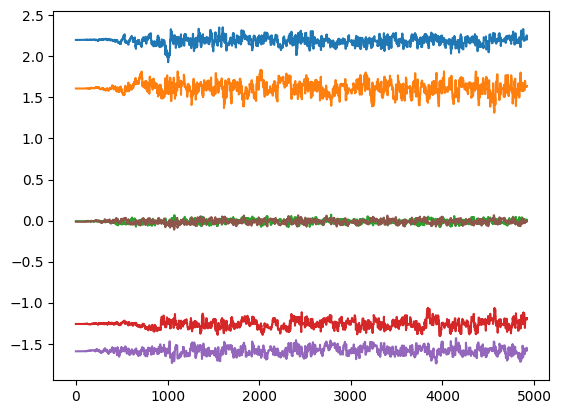

In [31]:
plt.plot(X)
plt.plot(Y)
plt.plot(a)
plt.plot(b)
plt.plot(c)
plt.plot(d)

In [32]:
from itertools import compress

In [33]:
chains_coarse = {"chain_coarse_{}".format(i): list(
                compress(chain.chain_coarse, chain.is_coarse)
            )
            for i, chain in enumerate(chains)
        }

In [34]:
for i, chain in enumerate(chains):
    print(chain.chain_coarse[i].parameters)

[ 2.20009603  1.60843624 -0.00660647 -1.25802381 -1.59124621 -0.01339086]


### Diagnostics

In [35]:
attribute="posterior"

In [36]:
idata_coarse_promoted = tda.to_inference_data(my_chain, level='promoted_coarse', burnin=burnin)
idata_fine = tda.to_inference_data(my_chain, level='fine', burnin=burnin)

/home/louisekluge/miniconda3/envs/tda/lib/python3.12/site-packages/arviz/data/inference_data.py:157: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


In [44]:
idata_coarse_promoted.qoi

<xarray.Dataset> Size: 12kB
Dimensions:  (chain: 2, draw: 501)
Coordinates:
  * chain    (chain) int64 16B 0 1
  * draw     (draw) int64 4kB 0 1 2 3 4 5 6 7 ... 494 495 496 497 498 499 500
Data variables:
    qoi_0    (chain, draw) float64 8kB 9.262 8.82 9.067 ... 9.353 8.81 8.815

In [60]:
idata_fine

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> qoi

In [51]:
qoi1 = idata_coarse_promoted.posterior
qoi2 = idata_fine.posterior

In [53]:
qoi1

<xarray.Dataset> Size: 5kB
Dimensions:  (chain: 2, draw: 501)
Coordinates:
  * chain    (chain) int64 16B 0 1
  * draw     (draw) int64 4kB 0 1 2 3 4 5 6 7 ... 494 495 496 497 498 499 500
Data variables:
    qoi_0    (chain, draw) bool 1kB True True True True ... True True True True

In [60]:
posterior_diff = qoi1-qoi2
print(posterior_diff.data_vars['x0'])

<xarray.DataArray 'x0' (chain: 2, draw: 501)> Size: 8kB
array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        -0.05975084, -0.05916442]])
Coordinates:
  * chain    (chain) int64 16B 0 1
  * draw     (draw) int64 4kB 0 1 2 3 4 5 6 7 ... 494 495 496 497 498 499 500


In [53]:
posterior_diff_dict = {var: posterior_diff[var] for var in posterior_diff.data_vars}

# 4. Create a new inference data object with the posterior difference
idata_diff = az.from_dict(posterior=posterior_diff_dict)

In [54]:
import arviz as az

In [64]:
az.summary(posterior_diff, var_names=["x0"]).loc["x0", "mean"]

-0.002

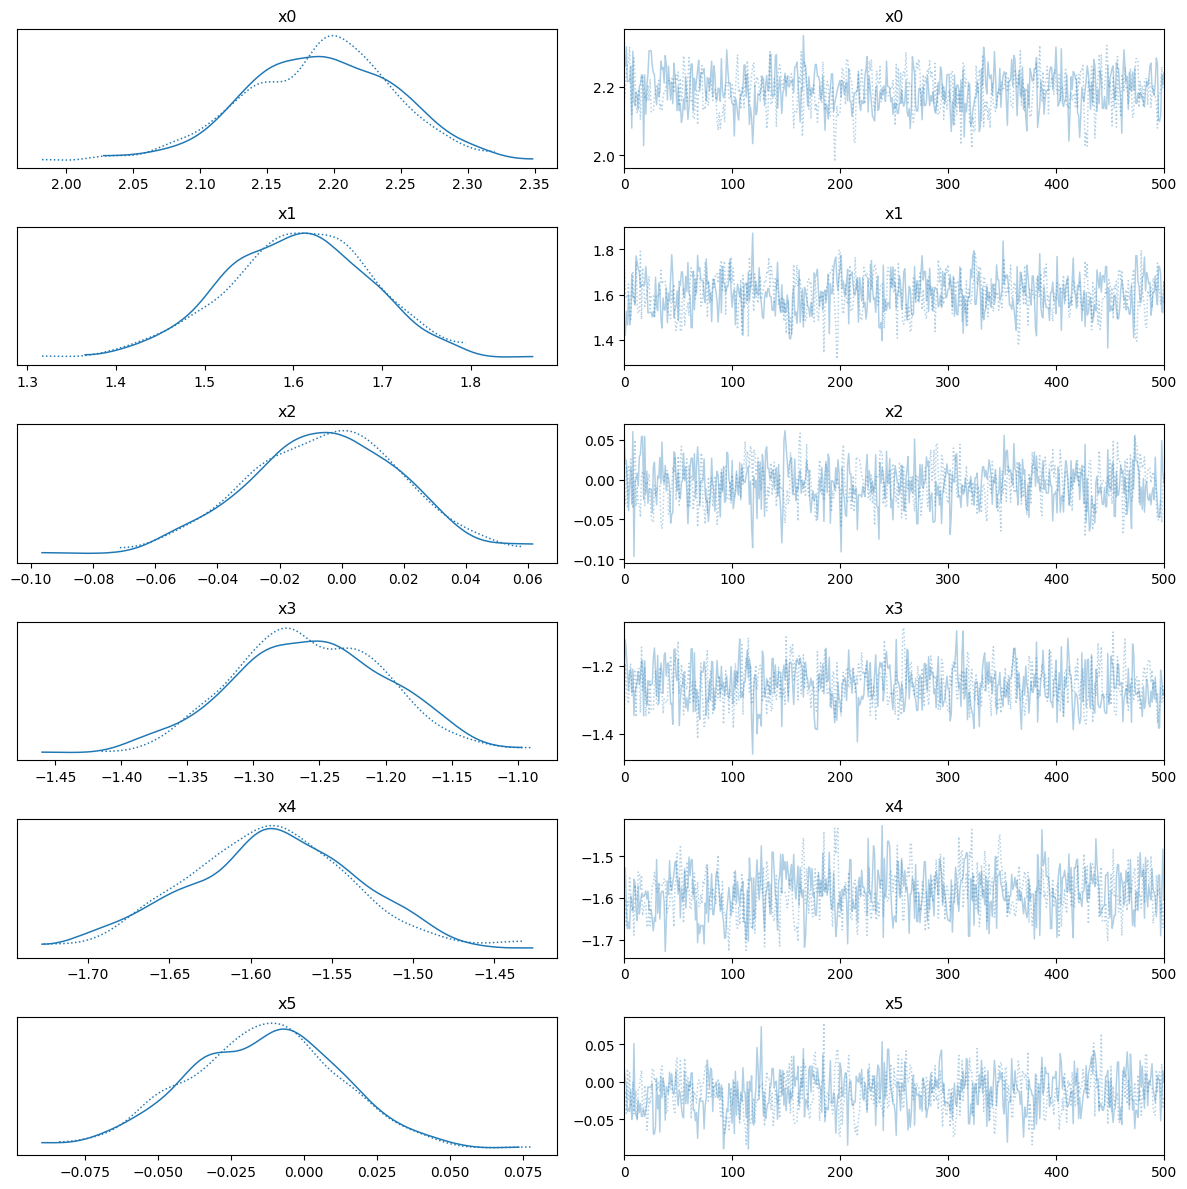

In [54]:
az.plot_trace(idata)
plt.tight_layout()
plt.show()